# 1. Importing Required Libraries

In [1]:
# Base -------------------------------------------
import numpy as np
import pandas as pd
import datetime

# Visualization -------------------------------------------
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from random import sample
from numpy.random import uniform
from math import isnan
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    warnings.filterwarnings("ignore", category=FutureWarning)
    warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(42)

# 2. Load the Data

In [2]:
# load the data
data = pd.read_csv('/content/customer_segmentation.csv')

# Create an extra copy
df = data.copy()
data.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# 3. Data Preprocessing and Feature Engineering

**Some Insights:**

* Income column had few null values and since the number is small it is better to drop those
* Date column is object type, need to convert it to datetype
* There is no need of birth year, however it can be used to extract Age
* Dataset also has multiple columns for the spent amount of various products which can be combined in one column called Total Spend
* Similarly kid home and teen home can be combined into children home
* Multiple accepted campaigns columns can be combined to a single total promo column

In [4]:
# Dropping the data points with null values
data.dropna(subset=['Income'], inplace=True)

# Converting object type to datetime format
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")

# Extracting Age from birth year
data['Age'] = 2015-data['Year_Birth']

# Extracting amount spent by each individual based on the purchase of various products
data['Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

# Combining total children at home
data['Children_home'] = (data['Kidhome'] + data['Teenhome'])

# Getting total promos used by each customer
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]

In [5]:
# Checking for all numerical columns
numerical_data = data.select_dtypes(include=['number']).columns

# Checking for all categorical columns
categorical_data = data.select_dtypes(include=['object']).columns

# Print unique values and value count inside each category
for values in categorical_data:
  #print(f'UNique values for column: {values}\n', df[values].unique()), print()
  print(f'Number of different values in the column {values}\n', data[values].value_counts())
  print('**'*20), print()

Number of different values in the column Education
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64
****************************************

Number of different values in the column Marital_Status
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64
****************************************



**Some Insights:**

* Column marital status and education has multiple values and they can be reduced to few
* It's also worth considering changing the name of few columns
* Using previously created columns, it's worth creating few more
* At last, dropping the unwanted columns

In [6]:
# Replacing values in the Education column
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate",
                                             "Graduation":"Graduate", "Master":"Postgraduate",
                                             "PhD":"Postgraduate"})

# Replacing values in the Marital Status column
data['Marital_Status'] = data['Marital_Status'].replace({'Married':'Partner','Together':'Partner',
                                                      'Single':'Alone','Divorced':'Alone',
                                                      'Widow':'Alone','Alone':'Alone',
                                                      'Absurd':'Alone','YOLO':'Alone'})

# Renaming columns
data = data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat",
                          "MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

# Creating two new columns
data["Is_Parent"] = np.where(data.Children_home	> 0, 1, 0)
data['Family_size'] = (data['Marital_Status'].replace({'Alone': 1, 'Partner': 2}) + data['Children_home'])

In [7]:
# Extracting customer tenure
earliest_date = data['Dt_Customer'].min()
data['Customer_Tenure'] = (pd.to_datetime('2015-01-01') - data['Dt_Customer']).dt.days

In [8]:
# Dropping unnecessary columns
to_drop = ["Z_CostContact", "Z_Revenue", "Year_Birth", "ID",'AcceptedCmp3', 'AcceptedCmp4',
           'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2','Dt_Customer']
data = data.drop(to_drop, axis=1)

In [9]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       NumWebVisitsMonth     Complain     Response          Age        Spent  \
count        2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean            5.319043     0.009477     0.150271    46.179603   607.075361   
std             2.425359     0.096907     0.357417    11.985554   602.900476   
min             0.000000     0.000000     0.000000    19.000000     5.000000   
25%             3.000000     0.000000     0.000000    38.000000    69.000000   
50%             6.000000     0.000000     0.000000    45.000000   396.500000   
75%             7.000000     0.000000     0.000000    56.000000  1048.000000   
max            20.000000     1.000000     1.000000   122.000000  2525.000000   

       Children_home  Total_Promos    Is_Parent  Family_size  Customer_Tenure  
count    2216.000000   2216.000000  2216.000000  2216.000000      2216.000000  
mean        0.947202      0.298285     0.714350     2.592509       539.521209  
std         0.749062      0.679209     0.451825     0.905722       202.434667  
min         0.000000      0.000000     0.000000     1.000000       186.000000  
25%         0.000000      0.000000     0.000000     2.000000       366.000000  
50%         1.000000      0.000000     1.000000     3.000000       541.500000  
75%         1.000000      0.000000     1.000000     3.000000       715.000000  
max         3.000000      4.000000     1.000000     5.000000       885.000000  

[8 rows x 24 columns]

# 4. Visualization and More

a. Distribution of numerical columns

b. Plotting box plot to catch potential outliers

In [10]:
fig=make_subplots(rows=5,cols=2,subplot_titles=('<i>Income', '<i>Age', '<i>Spent', '<i>Recency',
                                                '<i>Wines', '<i>Fruits', '<i>Meat', '<i>Fish',
                                                '<i>Sweets', '<i>Gold'))
fig.add_trace(go.Histogram(x=data['Income'],name='Income'),row=1,col=1)
fig.add_trace(go.Histogram(x=data['Age'],name='Age'),row=1,col=2)
fig.add_trace(go.Histogram(x=data['Spent'],name='Spent'),row=2,col=1)
fig.add_trace(go.Histogram(x=data['Recency'],name='Recency'),row=2,col=2)
fig.add_trace(go.Histogram(x=data['Wines'],name='Wines'),row=3,col=1)
fig.add_trace(go.Histogram(x=data['Fruits'],name='Fruits'),row=3,col=2)
fig.add_trace(go.Histogram(x=data['Meat'],name='Meat'),row=4,col=1)
fig.add_trace(go.Histogram(x=data['Fish'],name='Fish'),row=4,col=2)
fig.add_trace(go.Histogram(x=data['Sweets'],name='Sweets'),row=5,col=1)
fig.add_trace(go.Histogram(x=data['Gold'],name='Gold'),row=5,col=2)

fig.update_layout(height=1000,width=800,title_text='<b>Feature Distribution')
fig.update_layout(template='plotly_dark',title_x=0.5)

**Some Insights:**

* Age and Income seem to have some outliers
* As for the rest, it's better to check with the box plot

In [11]:
column_wise = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'Complain',
       'NumStorePurchases', 'Age', 'Children_home', 'Is_Parent','Family_size','Response']
for col in column_wise:
  fig = px.box(data,x=col, y='Spent',color=col,
        template='plotly_dark',
        color_discrete_sequence=px.colors.sequential.Plasma,
        title=f'<b>{col}-wise Spending')
  fig.show()

In [12]:
# Plot for checking outliers
fig=make_subplots(rows=6,cols=2,subplot_titles=('Age', 'Income', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'Complain',
       'NumStorePurchases', 'Children_home', 'Is_Parent','Family_size','Response'))

fig.add_trace(go.Box(y=data['Age'], name='Age'), row=1, col=1)
fig.add_trace(go.Box(y=data['Income'], name='Income'), row=1, col=2)
fig.add_trace(go.Box(y=data['NumDealsPurchases'], name='NumDealsPurchases'), row=2, col=1)
fig.add_trace(go.Box(y=data['NumWebPurchases'], name='NumWebPurchases'), row=2, col=2)
fig.add_trace(go.Box(y=data['NumCatalogPurchases'], name='NumCatalogPurchases'), row=3, col=1)
fig.add_trace(go.Box(y=data['Complain'], name='Complain'), row=3, col=2)
fig.add_trace(go.Box(y=data['NumStorePurchases'], name='NumStorePurchases'), row=4, col=1)
fig.add_trace(go.Box(y=data['Children_home'], name='Children_home'), row=4, col=2)
fig.add_trace(go.Box(y=data['Is_Parent'], name='Is_Parent'), row=5, col=1)
fig.add_trace(go.Box(y=data['Family_size'], name='Family_size'), row=5, col=2)
fig.add_trace(go.Box(y=data['Response'], name='Response'), row=6, col=1)


# FIgure update
fig.update_layout(height=2000,width=800,
                  title='Checking for Outliers',
                  template='ggplot2',
                  xaxis=dict(title='Feature'),
                  yaxis=dict(title='Values'))

fig.show()

* Income and age column have few outliers which is pointed out by describe method as well as the box plot.

In [13]:
def treat_outliers(column):
    # Removing outliers using Interquartile Range
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1

    # Define lower bound and upper bound
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter out the outliers
    column_filtered = column[(column >= lower_bound) & (column <= upper_bound)]

    return column_filtered

# Data without outliers
outlier_columns = ['Income', 'Age']
for column_name in outlier_columns:
    data[column_name] = treat_outliers(data[column_name])


In [14]:
# Plot for checking outliers
fig=make_subplots(rows=1,cols=2,subplot_titles=('Age', 'Income'))

fig.add_trace(go.Box(y=data['Age'], name='Age'), row=1, col=1)
fig.add_trace(go.Box(y=data['Income'], name='Income'), row=1, col=2)

# Fggure update
fig.update_layout(height=400,width=700,
                  title='After Treating the Outliers',
                  template='ggplot2',
                  xaxis=dict(title='Feature'),
                  yaxis=dict(title='Values'))

fig.show()

In [15]:
# Creating more columns from existing ones for better visualization
# Customer Category
bins = [0,90,365,730,2000]
labels = ['New Customers','Regular Customers','Potential Loyal Customers', 'Highly Loyal Customers']
data['Customer_category'] = pd.cut(data['Customer_Tenure'], bins=bins, labels=labels,right=False).astype('object')

# Age category
bins = [18,35,55,100]
labels = ['Young Adults','Senior Adult','Elder']
data['Age_cat'] = pd.cut(data['Age'], bins=bins, labels=labels,right=False).astype('object')

# Spender type
mean_spent = data.Spent.mean()
data['Spender_Type'] = ['Low spender' if spent < mean_spent else 'High spender' for spent in data['Spent']]

* We need to create more columns only for visualization so it is better to copy this data to another dataframe. Viz data is just a copy of already preprocessed data. The goal is to use viz data for visualization by creating even more categorical columns from existing numerical columns.

In [16]:
# Copy of data
viz_data = data.copy()

viz_data['Children_cat'] = viz_data['Children_home'].replace({0:'No child',1:'One child',
                                                              2:'Two child',3:'Three child'})

viz_data['Is_Parent_cat'] = viz_data['Is_Parent'].replace({0:'Not a Parent',1:'Is parent'})

viz_data['Family_size_cat'] = viz_data['Family_size'].replace({1:'Family of 1',2:'Family of 2',
                                                                   3:'Family of 3',4:'Family of 4',
                                                                   5:'Family of 5'})
viz_data['NumCatalogPurchases_cat'] = viz_data['NumCatalogPurchases'].replace({0:'0',1:'1',2:'2',3:'3',
                                                                                   4:'4',5:'5',6:'6',7:'7',
                                                                                   8:'8',9:'9',10:'10',11:'11',
                                                                                   28:'28',22:'22'})

web_purchase_mapping = {0: '0',1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',
                        8: '8',9: '9',10: '10',11: '11',23: '23',27: '27'}
viz_data['NumWebPurchases_cat'] = viz_data['NumWebPurchases'].replace(web_purchase_mapping)

store_purchase_mapping = {0: '0',1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',
                          8: '8',9: '9',10: '10',11: '11',12: '12',13: '13'}
viz_data['NumStorePurchases_cat'] = viz_data['NumStorePurchases'].replace(store_purchase_mapping)

web_visits_mapping = {0: '0',1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',8: '8',
                      9: '9',10: '10',13: '13',14: '14',17: '17',19: '19',20: '20'}
viz_data['NumWebVisitsMonth_cat'] = viz_data['NumWebVisitsMonth'].replace(web_visits_mapping)

deals_purchases_mapping = {0: '0',1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',
                           8: '8',9: '9',10: '10',11: '11',12: '12',13: '13',15: '15'}
viz_data['NumDealsPurchases_cat'] = viz_data['NumDealsPurchases'].replace(deals_purchases_mapping)


In [17]:
# Dropping null values
data.dropna(inplace=True)
viz_data.dropna(inplace=True)

In [18]:
# Get numerical and categorical columns
numerical_data = viz_data.select_dtypes(include=['number']).columns
categorical_data = viz_data.select_dtypes(include=['object']).columns

for column in categorical_data:
  #print(f'UNique values for column: {column}\n', df[column].unique()), print()
  print(f'Number of different values in the column {column}\n', viz_data[column].value_counts())
  print('**'*20), print()

Number of different values in the column Education
 Education
Graduate         1113
Postgraduate      840
Undergraduate     252
Name: count, dtype: int64
****************************************

Number of different values in the column Marital_Status
 Marital_Status
Partner    1422
Alone       783
Name: count, dtype: int64
****************************************

Number of different values in the column Customer_category
 Customer_category
Potential Loyal Customers    1164
Regular Customers             548
Highly Loyal Customers        493
Name: count, dtype: int64
****************************************

Number of different values in the column Age_cat
 Age_cat
Senior Adult    1219
Elder            607
Young Adults     379
Name: count, dtype: int64
****************************************

Number of different values in the column Spender_Type
 Spender_Type
Low spender     1304
High spender     901
Name: count, dtype: int64
****************************************

Number of differe

In [19]:
# Plot total spend within each category
for column in categorical_data:
  grouped_data = viz_data.groupby(column, as_index=False).agg({'Spent': 'sum'})

  fig = px.histogram(grouped_data.sort_values(by='Spent', ascending=False),
                       x=column,
                       y='Spent',
                       color=column,
                       color_discrete_sequence=px.colors.sequential.Plasma_r,
                       template='plotly_dark',
                       marginal='box',
                       title=f'<b>Total Spent based on {column}</b>')

  fig.update_layout(title_x=0.5)
  fig.show()

**Summary: For Total Spend**

* People who are Graduates, Partners and have no child are spending most
* Non-parents are spending just a little more than parents
* A family of 2 that is just partners with no child are spending more followed by the family of 3
* Customers with just 1 deal purchase spent more
* Customers who visited website twice or thrice spent more

In [20]:
# Plot average spend within each category
for column in categorical_data:
  grouped_data = viz_data.groupby(column, as_index=False).agg({'Spent': 'mean'})

  fig = px.histogram(grouped_data.sort_values(by='Spent', ascending=False),
                       x=column,
                       y='Spent',
                       color=column,
                       color_discrete_sequence=px.colors.sequential.Plasma_r,
                       template='plotly_dark',
                       marginal='box',
                       title=f'<b>Average Spent based on {column}</b>')

  fig.update_layout(title_x=0.5)
  fig.show()

**Summary: For an Average Spend**

* In the case of total spend where graduates spent the most, on average postgraduates are spending more followed by graduates and undergraduates
* The same is the case with marital status where on average who are alone are spendind more than partners
* A high spender customer on avg spends about 1200 USD and a low spender customer spends about 170 USD
* Customer with no child and belongs to Not a parent category spent more on average
* Family of 1 spends more on average that again suggests that customers who are alone are spending more on average followed by family of 2.

In [21]:
# Relationship among various features
fig=px.imshow(viz_data[numerical_data].corr(),text_auto=True,height=700,width=700,
              color_continuous_scale=px.colors.sequential.Greens,
              aspect='auto',
              template='plotly_dark',
              title='<b>Pairwise correlation of columns')
fig.update_layout(title_x=0.5)
fig.show()

**Summary: Correlation Between Features**

* Columns having extremely high positive correlations with column Spent are: Wines, Income, Gold, Fish, Sweets, Meat, Fruits, NumWebPurchases, NumCatalogPurchases, NumStorePurchases
* Columns having high negative correlations with column Spent are:Kidhome, childrenhome, NumWebVisits, Is Parent
* Multicollinearity is present too that might need some attention

In [22]:
# Plotting to see the sub-category contributing the most within another category
fig=px.treemap(viz_data,path=[px.Constant('Shopping'),'Marital_Status','Children_cat', 'Age_cat'],
               values='Spent',
               color='Children_cat',
               template='plotly_dark',
               color_discrete_map={'(?)':'greenyellow', 'One child':'steelblue', 'No child':'teal',
                                   'Two child':'burlywood','Three child':'dodgerblue','Footwear':'whitesmoke'},
               title='<b>TreeMap of Shopping by Marital Status')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_layout(title_x=0.5)

**Summary: Treemap Showing the Total Spending by Various Categories**

* The order of spending under each category are: Marital Status -> Partner followed by Alone
  * Those who are partner, and have no child
  * Those who are partner, have no child and are Senior adult and elder
  * The same is true for category 'Alone'

In [23]:
# Plotting to see the sub-category contributing the most within another category
fig=px.treemap(viz_data,path=[px.Constant('Shopping'),'Age_cat','Spender_Type','Family_size'],
               values='Spent',
               color='Spender_Type',
               template='plotly_dark',
               color_discrete_map={'(?)':'greenyellow', 'High spender':'steelblue', 'Low spender':'teal'},
               title='<b>TreeMap of Shopping by Age Catgory')
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.update_layout(title_x=0.5)

**Summary: Treemap Showing the Total Spending by Various Categories**

* The order of spending under each category are: Age Category -> Senior Adult followed by Elder
  * Those who are Senior Adult, and are High Spender
  * Those who are Senior Adult, High Spender and have a family of 2 or 3.
  * The same is true for Elder customers

In [24]:
# Plot average spent by age category
fig = px.histogram(viz_data.groupby('Age_cat', as_index=False).agg({'Spent': 'mean'}).sort_values(by='Spent', ascending=False),
                       x='Age_cat',
                       y='Spent',
                       color='Age_cat',
                       color_discrete_sequence=px.colors.sequential.Plasma_r,
                       template='plotly_dark',
                       marginal='box',
                       title='<b>Average Spent based on Age Category</b>')

fig.update_layout(title_x=0.5)
fig.show()

**Summary: Average spending by age category**

* On average, elders spent the most

In [25]:
# Spend by demographic data
column_wise = ['Kidhome','Teenhome','Age','Children_home','Is_Parent','Family_size',
               'Response','Complain', 'Customer_category']
for col in column_wise:
  fig = px.box(viz_data,x=col, y='Spent',color=col,
        template='plotly_dark',
        color_discrete_sequence=px.colors.sequential.Plasma,
        title=f'<b>{col}-wise Spending')
  fig.show()

**Summary: Amount of Spending by demographic details**

* Customers with 0 Kids, 0 teens, family size of 1 and 2 spends more
* It is also worth noting that highly loyal customers spent more than regular customers

In [26]:
# Average spend by products
columns_to_average = ['Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold']
Average_purchase_price_by_product = viz_data[columns_to_average].mean()
print('The Average Spending Amount by Product:\n', Average_purchase_price_by_product)

The Average Spending Amount by Product:
 Wines     306.164626
Fruits     26.403175
Meat      165.312018
Fish       37.756463
Sweets     27.128345
Gold       44.057143
dtype: float64


In [27]:
# Frequency of web purchases based on number of visits
cross_tab_web = pd.crosstab(index=data['NumWebVisitsMonth'],
                                  columns=data['NumWebPurchases'],
                                  margins=True, margins_name='Total')
cross_tab_web

NumWebPurchases     0    1    2    3    4    5    6    7    8   9  10  11  23  \
NumWebVisitsMonth                                                               
0                   0    1    2    2    0    0    0    0    0   0   0   0   1   
1                   1    3   25   61   41   11    2    0    0   0   0   0   0   
2                   1   11    9   26   67   51   30    6    0   0   0   0   0   
3                   5   18   14   22   35   38   41   17   10   2   1   0   0   
4                   7   33   28   20   18   18   33   31   15   7   3   3   0   
5                   8   39   61   20   24   27   22   35   14  20   3   5   0   
6                   7   56   80   36   21   22   22   20   26  19  12  13   0   
7                   5   95   82   56   32   18   29   17   23  13   7  10   0   
8                   2   76   53   69   28   28   16   22   13  10  13  10   0   
9                   0   11   12   21   10    5    6    6    1   3   4   3   0   
10                  0    0    1    0    0    1    0    0    0   1   0   0   0   
13                  0    1    0    0    0    0    0    0    0   0   0   0   0   
14                  2    0    0    0    0    0    0    0    0   0   0   0   0   
17                  0    1    0    0    0    0    0    0    0   0   0   0   0   
19                  2    0    0    0    0    0    0    0    0   0   0   0   0   
20                  2    1    0    0    0    0    0    0    0   0   0   0   0   
Total              42  346  367  333  276  219  201  154  102  75  43  44   1   

NumWebPurchases    25  27  Total  
NumWebVisitsMonth                 
0                   0   0      6  
1                   1   1    146  
2                   0   0    201  
3                   0   0    203  
4                   0   0    216  
5                   0   0    278  
6                   0   0    334  
7                   0   0    387  
8                   0   0    340  
9                   0   0     82  
10                  0   0      3  
13                  0   0      1  
14                  0   0      2  
17                  0   0      1  
19                  0   0      2  
20                  0   0      3  
Total               1   1   2205

**Summary: Website visit and Number of Purchases**

* Customers who visited website 2 to 8 times, purchased more on the web

#5. Dimensionality Reduction

In [28]:
from sklearn.decomposition import PCA, IncrementalPCA

##5.1 Preprocessing

In [29]:
df = data.copy()

In [30]:
# one hot encoding categorical column
one_hot_columns = ['Marital_Status', 'Spender_Type']
for column in one_hot_columns:
  df = pd.get_dummies(df, columns=[column], prefix=column, drop_first=True, dtype=int)

education_mapping = {'Undergraduate': 0, 'Graduate': 1, 'Postgraduate': 2}
df['Education'] = df['Education'].map(education_mapping)
age_mapping = {'Young Adults': 0, 'Elder': 1, 'Senior Adult': 2}
df['Age_cat'] = df['Age_cat'].map(age_mapping)

In [31]:
# final data is data without customer category and age category
final_data = df.drop(columns=['Customer_category', 'Age_cat'], axis=1, inplace=False)
final_data.to_csv('final_data', index=False)

In [32]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2205 entries, 0 to 2239
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Education                 2205 non-null   int64  
 1   Income                    2205 non-null   float64
 2   Kidhome                   2205 non-null   int64  
 3   Teenhome                  2205 non-null   int64  
 4   Recency                   2205 non-null   int64  
 5   Wines                     2205 non-null   int64  
 6   Fruits                    2205 non-null   int64  
 7   Meat                      2205 non-null   int64  
 8   Fish                      2205 non-null   int64  
 9   Sweets                    2205 non-null   int64  
 10  Gold                      2205 non-null   int64  
 11  NumDealsPurchases         2205 non-null   int64  
 12  NumWebPurchases           2205 non-null   int64  
 13  NumCatalogPurchases       2205 non-null   int64  
 14  NumStorePurch

##5.2 Data Standardization

In [33]:
# Standardize data for PCA
scaler = StandardScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(final_data), columns=final_data.columns)
scaled_data

Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0     -0.409469  0.314651 -0.823405 -0.930767  0.310830  0.974566  1.548614   
1     -0.409469 -0.254877  1.038757  0.906602 -0.380600 -0.874776 -0.638664   
2     -0.409469  0.965354 -0.823405 -0.930767 -0.795458  0.355155  0.568110   
3     -0.409469 -1.206087  1.038757 -0.930767 -0.795458 -0.874776 -0.563241   
4      1.126039  0.322136  1.038757 -0.930767  1.555404 -0.394659  0.417263   
...         ...       ...       ...       ...       ...       ...       ...   
2200  -0.409469  0.463624 -0.823405  0.906602 -0.104028  1.193879  0.417263   
2201   1.126039  0.598401  2.900920  0.906602  0.241687  0.295881 -0.663806   
2202  -0.409469  0.258780 -0.823405 -0.930767  1.451690  1.783653  0.542969   
2203   1.126039  0.851004 -0.823405  0.906602 -1.417746  0.361082  0.090428   
2204   1.126039  0.060213  1.038757  0.906602 -0.311457 -0.658427 -0.588382   

          Meat      Fish    Sweets  ...  Response       Age     Spent  \
0     1.748400  2.449154  1.480301  ...  2.370996  1.017189  1.679323   
1    -0.731678 -0.652345 -0.635399  ... -0.421764  1.273530 -0.963897   
2    -0.175957  1.336263 -0.149031  ... -0.421764  0.333612  0.281242   
3    -0.667380 -0.506392 -0.586763  ... -0.421764 -1.289883 -0.920675   
4    -0.217292  0.150396 -0.003121  ... -0.421764 -1.033542 -0.307248   
...        ...       ...       ...  ...       ...       ...       ...   
2200  0.076644  0.077420  2.209853  ... -0.421764  0.162718  1.220500   
2201 -0.621452 -0.688833 -0.659718  ... -0.421764  1.957107 -0.270675   
2202  0.237389 -0.105022 -0.367897  ... -0.421764 -1.033542  1.054260   
2203  0.223611  0.770696  0.069834  ... -0.421764  1.102636  0.392623   
2204 -0.479078 -0.652345 -0.635399  ...  2.370996  1.273530 -0.722849   

      Children_home  Total_Promos  Is_Parent  Family_size  Customer_Tenure  \
0         -1.266589     -0.439991   -1.58466    -1.759012         1.527183   
1          1.403420     -0.439991    0.63105     0.448513        -1.188629   
2         -1.266589     -0.439991   -1.58466    -0.655250        -0.205999   
3          0.068415     -0.439991    0.63105     0.448513        -1.060245   
4          0.068415     -0.439991    0.63105     0.448513        -0.951612   
...             ...           ...        ...          ...              ...   
2200       0.068415     -0.439991    0.63105     0.448513         0.134712   
2201       2.738424      1.029979    0.63105     2.656038        -1.652786   
2202      -1.266589      1.029979   -1.58466    -1.759012        -0.981239   
2203       0.068415     -0.439991    0.63105     0.448513        -0.976302   
2204       1.403420     -0.439991    0.63105     1.552276         1.324732   

      Marital_Status_Partner  Spender_Type_Low spender  
0                  -1.347625                 -1.203030  
1                  -1.347625                  0.831235  
2                   0.742046                 -1.203030  
3                   0.742046                  0.831235  
4                   0.742046                  0.831235  
...                      ...                       ...  
2200                0.742046                 -1.203030  
2201                0.742046                  0.831235  
2202               -1.347625                 -1.203030  
2203                0.742046                 -1.203030  
2204                0.742046                  0.831235  

[2205 rows x 27 columns]

In [34]:
# Instantiate and fit the data
pca = PCA(random_state = 42, svd_solver = 'full')
pca.fit(scaled_data)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"Minimum number of dimensions required to preserve 95% of the variance is {d}")

Minimum number of dimensions required to preserve 95% of the variance is 18


In [35]:
# Another way to confirm this
pca_alt = PCA(n_components = 0.95)
df1_reduced = pca_alt.fit_transform(scaled_data)
print("Number or components: ", pca_alt.n_components_)
print("Variance captured by 18 components: ", cumsum[18])

Number or components:  18
Variance captured by 18 components:  0.9630997644214706


In [36]:
# Plot explained variance ratio and cumulative explained variance ratio
variance_ratio = pca.explained_variance_ratio_

cumulative_variance_ratio = variance_ratio.cumsum()

fig_variance_ratio = go.Figure()
fig_variance_ratio.add_trace(go.Bar(x=list(range(1, len(variance_ratio) + 1)),
                                    y=variance_ratio,
                                    marker_color='royalblue',
                                    name='Variance Ratio'))
fig_variance_ratio.add_trace(go.Scatter(x=list(range(1, len(cumulative_variance_ratio) + 1)),
                                        y=cumulative_variance_ratio,
                                        mode='lines',
                                        line=dict(color='red', width=2),
                                        name='Cumulative Variance Ratio'))
fig_variance_ratio.update_layout(title='Variance Ratio and Cumulative Variance Ratio',
                                 xaxis_title='Principal Component',
                                 yaxis_title='Variance Ratio')



fig_variance_ratio.show()


**Insight:**
* PC 1 explains 34% of variance, PC2 explains 11% and so on
* We need to reduce original dataframe from 27 features to 18 features.

In [37]:
# Initiating PCA to reduce dimensions to 18
pca = PCA(n_components = 18, random_state = 42, svd_solver = 'full')
pca.fit(scaled_data)
pca_data = pd.DataFrame(pca.transform(scaled_data), columns = (['col1', 'col2', 'col3', 'col4',
                                                                  'col5', 'col6', 'col7', 'col8',
                                                                  'col9', 'col10', 'col11', 'col12',
                                                                  'col13', 'col14', 'col15', 'col16',
                                                                  'col17', 'col18']))

In [38]:
pca_data

col1      col2      col3      col4      col5      col6      col7  \
0     5.212520 -0.527147  2.682835  0.829850 -1.292423  0.468036 -0.008093   
1    -3.081753  0.034237 -1.152782 -1.033076 -0.632489  1.792244 -0.565942   
2     2.674895 -0.798439 -0.774711  0.385621 -0.337804 -0.520430  1.671148   
3    -2.922070 -1.477658 -0.311327  0.545403  1.193575  0.306855  0.358540   
4    -0.911823  0.291380 -0.632786  0.700441  0.771243 -0.688839 -1.585446   
...        ...       ...       ...       ...       ...       ...       ...   
2200  2.465624  2.250866 -0.098325  1.719922 -0.336954  0.036434  0.694046   
2201 -2.909362  4.291037 -0.591124 -1.214805  1.821880  0.445967 -1.204292   
2202  2.924633 -1.891441  0.126612 -0.655244 -0.765593 -1.053780 -1.859268   
2203  1.744903  1.897443 -1.832603 -0.935808  0.032978  0.694018  1.442045   
2204 -2.601477  1.824987  1.160023 -1.183146  0.964696  0.181843  0.724998   

          col8      col9     col10     col11     col12     col13     col14  \
0     0.158303  0.152080 -2.440790  0.638711  1.148298 -0.209498  0.023214   
1     0.106292  0.823821 -0.566672 -0.167095  0.351519  0.539143 -0.585535   
2    -0.322002 -0.418051  0.787585 -0.097945  0.729390 -0.328623 -0.542106   
3    -0.441208 -0.614107  0.982306  0.101592  0.255579  0.096604 -0.045554   
4    -0.230287 -1.603577  0.280272  1.020382  1.049300 -0.402111  0.923673   
...        ...       ...       ...       ...       ...       ...       ...   
2200 -0.527718  1.219385  0.604720  2.103938 -1.368757 -1.203277 -0.794279   
2201  0.026714 -0.204153 -0.158148  1.134567  2.714085  0.245768 -1.027810   
2202  0.047475 -0.060761  1.886692 -1.086635  0.281746  0.536238 -0.338259   
2203 -0.333097 -0.704981  0.416294  0.294451 -0.177086  0.065559 -0.201264   
2204  0.251263 -0.088017 -2.416792  0.185974 -0.383154 -0.169635  0.733474   

         col15     col16     col17     col18  
0    -0.817974 -0.003747  1.679772  0.133590  
1    -0.174333  0.049604  0.059018  0.296763  
2    -0.777606 -0.399137 -0.427569 -1.283197  
3    -0.088228 -0.016410 -0.043724 -0.116233  
4     0.198147 -0.227197 -0.096726 -0.388732  
...        ...       ...       ...       ...  
2200 -0.267819  1.417895 -0.009273  1.640381  
2201 -0.081811  0.101043 -0.577418 -0.095323  
2202  0.729229 -1.256897 -0.730862 -0.405982  
2203 -0.209111  0.150939  0.153416 -0.518445  
2204 -0.811848 -0.015408 -0.629635 -0.354862  

[2205 rows x 18 columns]

#6. Clustering


##6.1 Importing Required Library

In [39]:
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, f1_score

##6.2 Clustering the Data

In [40]:
def hopkins(X):
    d = X.shape[1]   # 22:number of columns
    n = len(X)       # 2216:number of rows
    m = int(0.1 * n)  # 221:10 percent of total observation
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)

    rand_X = sample(range(0, n, 1), m)

    # to store distance between the points
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])

    HS = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(HS):
        print(ujd, wjd)
        HS = 0

    return HS

print(hopkins(pca_data))

0.8537526649047421


**Insights:** Hopkins score or Hopkins index, is a measure used to assess the clustering tendency of a dataset. It quantifies the degree of clustering in a dataset by comparing the distribution of the data points to a uniform distribution.

Ranges between 0 to 1, where 1 indicates high clustering structure within data

**Choosing the number of cluster using Elbow method**

* Inertia ia a metric used to evaluate the quality of a clustering solution. It measures the compactness of the clusters, quantifying how far the points within a cluster are from the centroid of that cluster. The inertia for a particular cluster is the sum of the squared distances between each data point in the cluster and the centroid of the cluster.
* The objective of the K-means algorithm is to minimize the overall inertia, meaning that the data points within each cluster should be as close as possible to their cluster's centroid.
* Lower inertia values indicate that the data points are closer to the centroids of their respective clusters, implying a better, more compact clustering.
* When using K-means to find the optimal number of clusters, you can plot the inertia for different values of K (number of clusters) and look for the "elbow" in the plot. The point where the reduction in inertia starts to slow down (the "elbow") is often considered the optimal number of clusters. This technique is known as the Elbow Method.



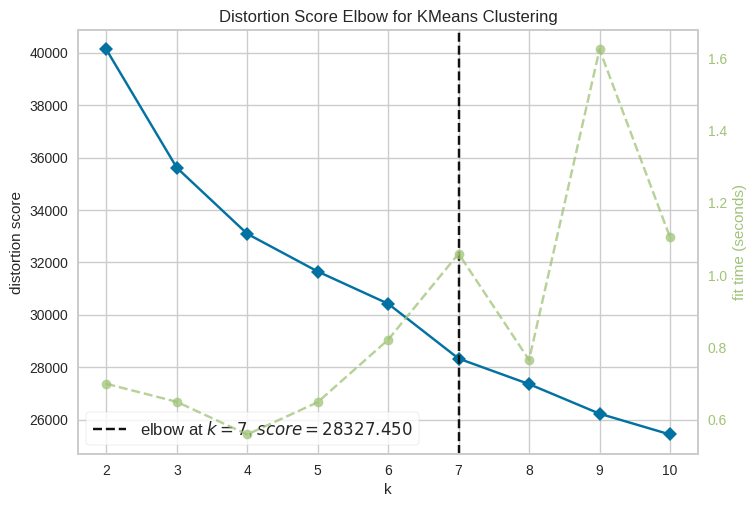

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [41]:
elbow_method = KElbowVisualizer(KMeans(n_init=10))

elbow_method.fit(pca_data)
elbow_method.show()

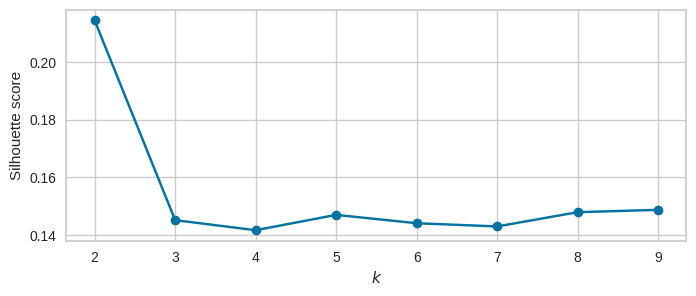

In [42]:
kmeans_per_k = [KMeans(n_clusters=k, n_init=10, random_state=42).fit(scaled_data)
                for k in range(2, 11)]

silhouette_scores = [silhouette_score(scaled_data, model.labels_)
                     for model in kmeans_per_k[1:]]

plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$")
plt.ylabel("Silhouette score")

plt.grid(True)
plt.show()


In [43]:
cluster_range = range(2, 10)
for i, score in zip(cluster_range, silhouette_scores):
  print(f"Silhouette Score for {i} Clusters:", score)

Silhouette Score for 2 Clusters: 0.21448627441337345
Silhouette Score for 3 Clusters: 0.1451856175178692
Silhouette Score for 4 Clusters: 0.1416829790483903
Silhouette Score for 5 Clusters: 0.14700245129374065
Silhouette Score for 6 Clusters: 0.14410723589402397
Silhouette Score for 7 Clusters: 0.1429924990284293
Silhouette Score for 8 Clusters: 0.14793490579688667
Silhouette Score for 9 Clusters: 0.14875123184614858


**Insights:**
* Clusters 3 to 9 does not show any huge difference
* Cluster 2 and 3 seem to be the right choice

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



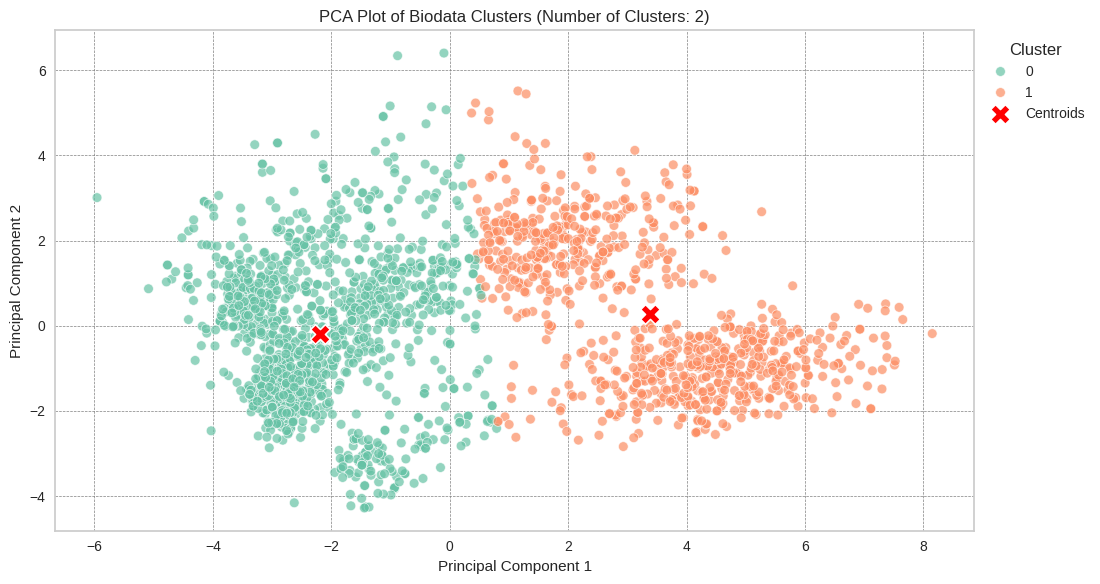

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



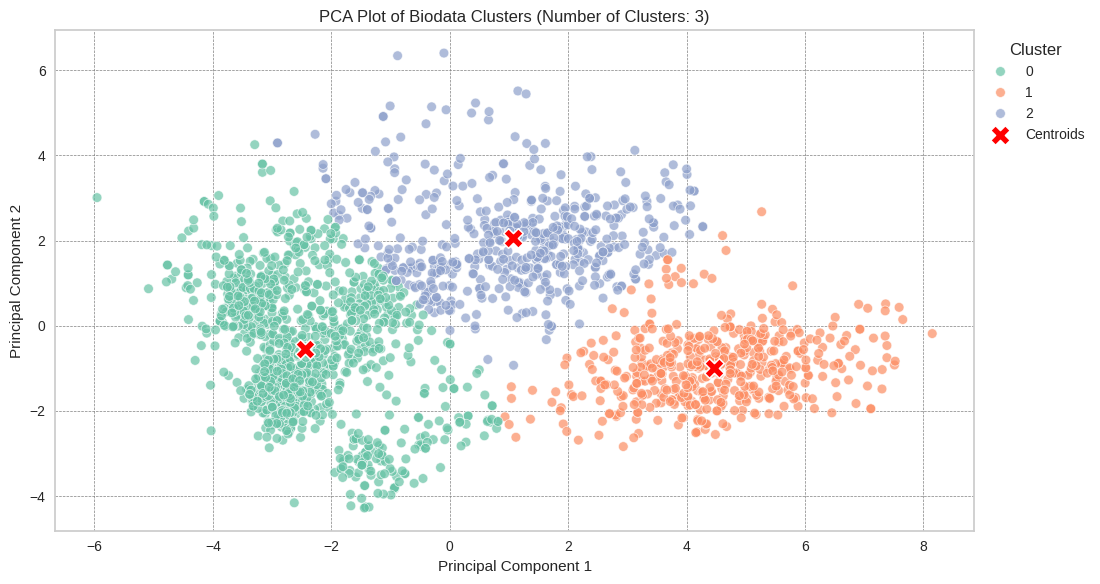

In [44]:
# Define the range of cluster counts to iterate over
cluster_counts = [2, 3]

# Standardize and perform PCA on the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(final_data)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(normalized_data)

final_data['PC1'] = pca_data[:, 0]
final_data['PC2'] = pca_data[:, 1]

# Plot for each cluster count
for n_clusters in cluster_counts:
    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_data)
    final_data['Cluster'] = cluster_labels

    # Plot the clusters
    cluster_palette = sns.color_palette("Set2", n_colors=n_clusters)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=final_data, x='PC1', y='PC2', hue='Cluster', palette=cluster_palette, alpha=0.7)

    plt.title(f"PCA Plot of Biodata Clusters (Number of Clusters: {n_clusters})")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()

    # Add centroids to the plot
    sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1], marker='X', s=200, color='red', label='Centroids')

    plt.legend(title="Cluster", bbox_to_anchor=(1, 1), loc='upper left')
    plt.grid(color='gray', linestyle='--', linewidth=0.5)

    plt.show()

**Insight:**
* Cluster 2 shows a clear separtation however in cluster 3 a bit of overlapping can be observed.


### Cluster 3

In [45]:
final_data.drop(columns=['Cluster', 'PC1', 'PC2'], axis=1, inplace=True)

In [46]:
cluster3 = KMeans(n_clusters=3, n_init=10, random_state= 42)
cluster3.fit(pca_data)
final_data['cluster3'] = cluster3.labels_

In [47]:
final_data.head()

Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  Meat  Fish  \
0          1  58138.0        0         0       58    635      88   546   172   
1          1  46344.0        1         1       38     11       1     6     2   
2          1  71613.0        0         0       26    426      49   127   111   
3          1  26646.0        1         0       26     11       4    20    10   
4          2  58293.0        1         0       94    173      43   118    46   

   Sweets  ...   Age  Spent  Children_home  Total_Promos  Is_Parent  \
0      88  ...  58.0   1617              0             0          0   
1       1  ...  61.0     27              2             0          1   
2      21  ...  50.0    776              0             0          0   
3       3  ...  31.0     53              1             0          1   
4      27  ...  34.0    422              1             0          1   

   Family_size  Customer_Tenure  Marital_Status_Partner  \
0            1              849                       0   
1            3              299                       0   
2            2              498                       1   
3            3              325                       1   
4            3              347                       1   

   Spender_Type_Low spender  cluster3  
0                         0         1  
1                         1         0  
2                         0         1  
3                         1         0  
4                         1         0  

[5 rows x 28 columns]

In [48]:
cluster_counts = final_data["cluster3"].value_counts().reset_index()
cluster_counts.columns = ["Cluster", "Count"]

# Create a Plotly bar plot
fig = px.bar(cluster_counts, x="Cluster", y="Count",
             labels={"Cluster": "Cluster", "Count": "Count"},
             title="Distribution Of The Clusters",
             color_discrete_sequence=px.colors.sequential.Plasma_r,
             template='plotly_dark')

# Show the plot
fig.show()

**Insights:** : Most of the data falls under Cluster 1 followed by cluster 2

<Axes: xlabel='Gold', ylabel='Spent'>

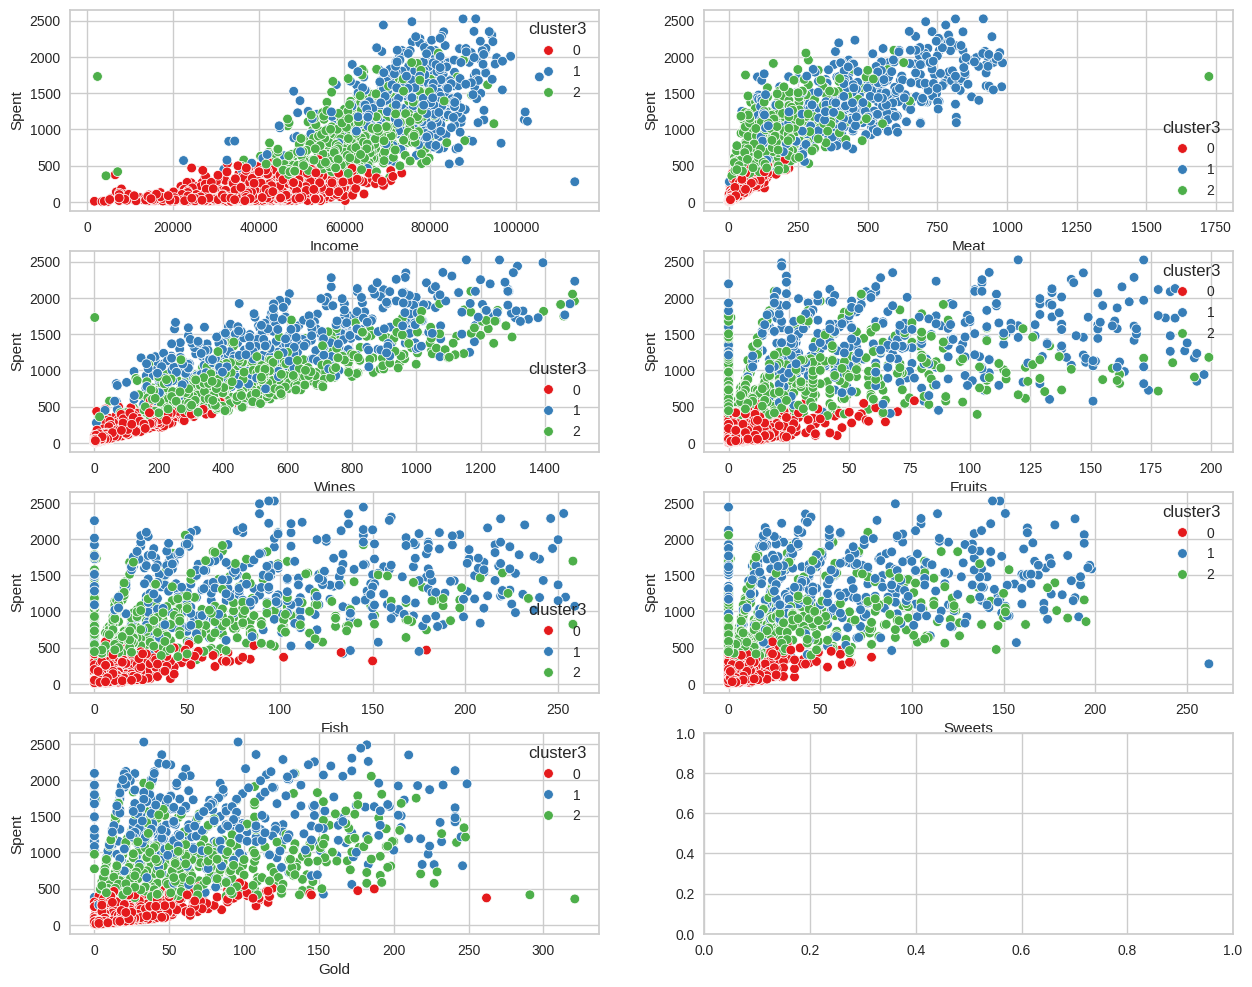

In [49]:
fig, axes = plt.subplots(4,2, figsize=(15,12))

sns.scatterplot(x = 'Income', y = 'Spent',hue='cluster3',
                data = final_data, legend='full',palette="Set1",ax=axes[0][0])
sns.scatterplot(x = 'Meat', y = 'Spent',hue='cluster3',
                data = final_data, legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'Wines', y = 'Spent',hue='cluster3',
                data=final_data, legend='full',palette="Set1",ax=axes[1][0])
sns.scatterplot(x = 'Fruits', y = 'Spent',hue='cluster3',
                data=final_data, legend='full',palette="Set1",ax=axes[1][1])
sns.scatterplot(x = 'Fish', y = 'Spent',hue='cluster3',
                data=final_data, legend='full',palette="Set1",ax=axes[2][0])
sns.scatterplot(x = 'Sweets', y = 'Spent',hue='cluster3',
                data=final_data, legend='full',palette="Set1",ax=axes[2][1])
sns.scatterplot(x = 'Gold', y = 'Spent',hue='cluster3',
                data=final_data, legend='full',palette="Set1",ax=axes[3][0])

**Summary:** All the clusters are overlapping. Time to check if reducing the number of cluster can be of any help.

### Cluster 2

In [50]:
cluster2 = KMeans(n_clusters=2, n_init=10, random_state= 42)
cluster2.fit(pca_data)
final_data['Cluster2'] = cluster2.labels_

In [52]:
cluster_counts = final_data["Cluster2"].value_counts().reset_index()
cluster_counts.columns = ["Cluster", "Count"]

fig = px.bar(cluster_counts, x="Cluster", y="Count",
             labels={"Cluster": "Cluster", "Count": "Count"},
             title="Distribution Of The Clusters",
             color_discrete_sequence=px.colors.sequential.Plasma_r,
             template='plotly_dark')

fig.show()

**Summary** : Most of the data falls under Cluster 0

<Axes: xlabel='Gold', ylabel='Spent'>

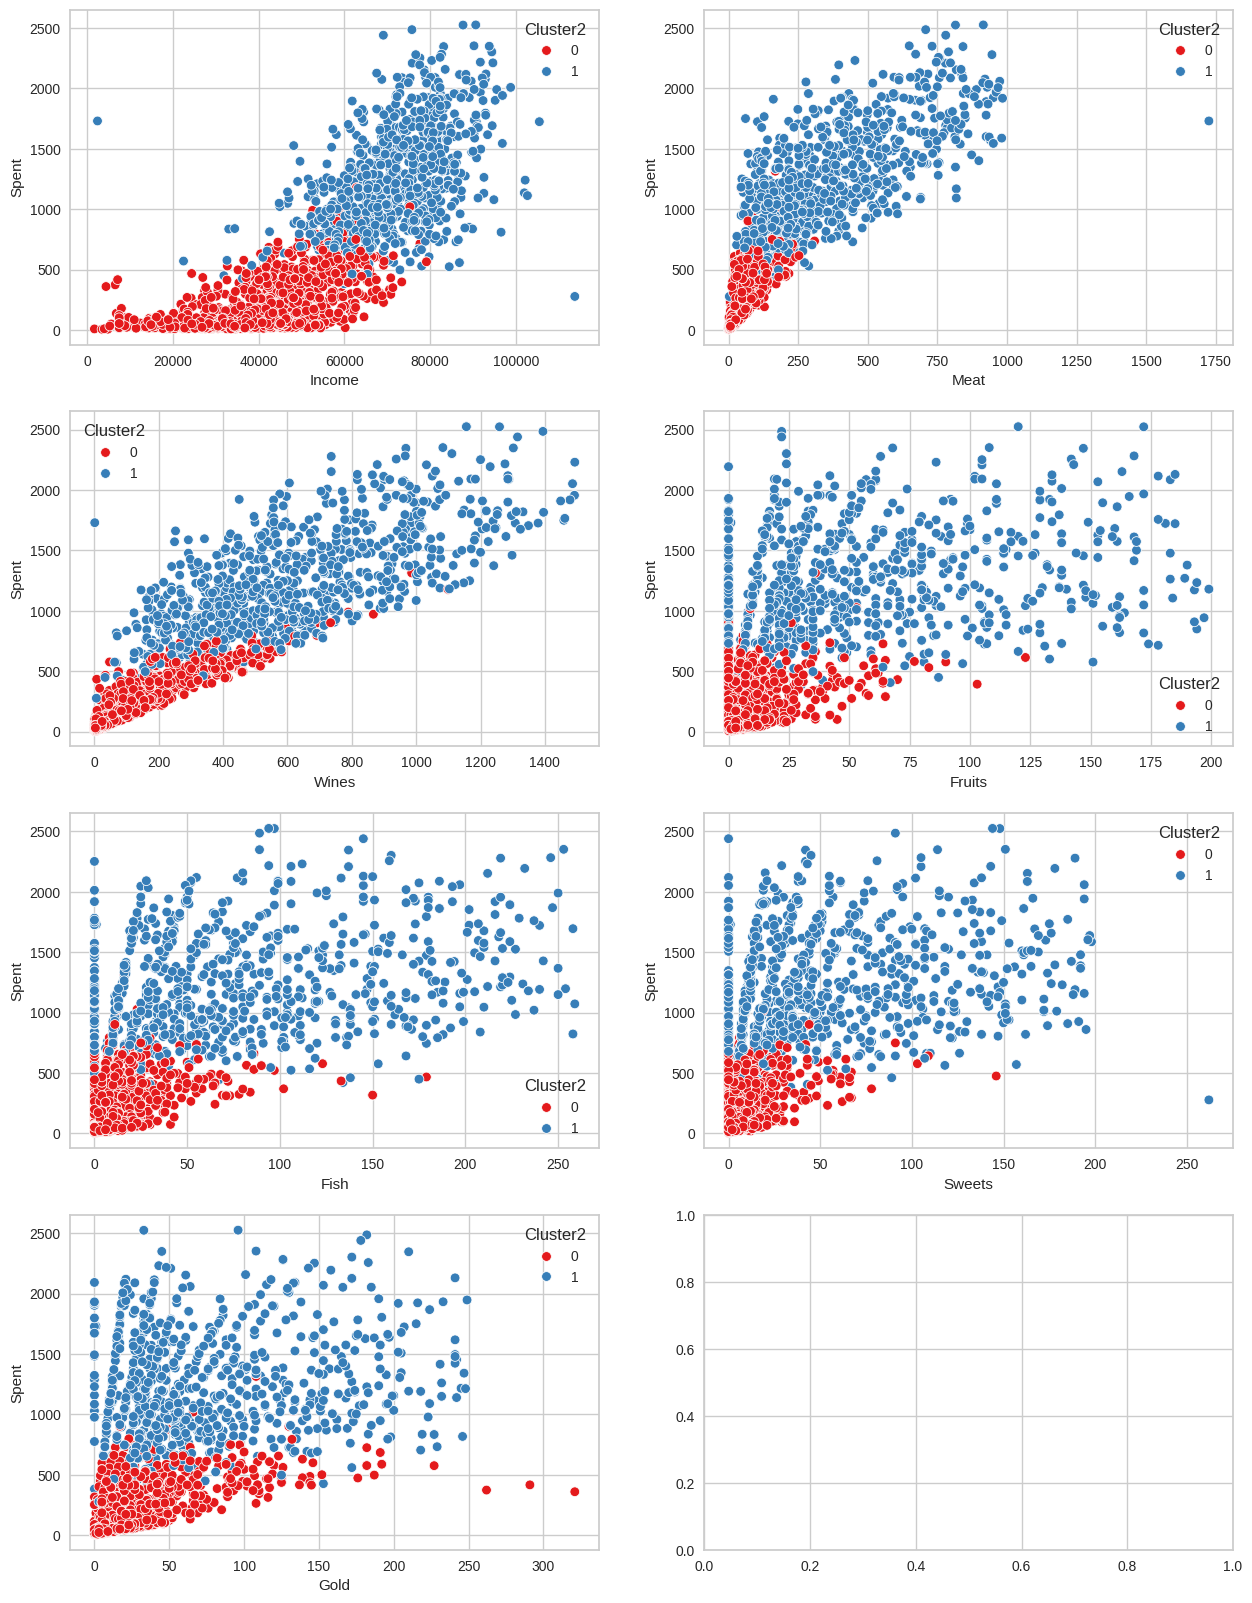

In [54]:
fig, axes = plt.subplots(4,2, figsize=(15,20))

sns.scatterplot(x = 'Income', y = 'Spent',hue='Cluster2',
                data = final_data, legend='full',palette="Set1", ax=axes[0][0])
sns.scatterplot(x = 'Meat', y = 'Spent',hue='Cluster2',
                data = final_data, legend='full',palette="Set1",ax=axes[0][1])
sns.scatterplot(x = 'Wines', y = 'Spent',hue='Cluster2',
                data=final_data, legend='full',palette="Set1",ax=axes[1][0])
sns.scatterplot(x = 'Fruits', y = 'Spent',hue='Cluster2',
                data=final_data, legend='full',palette="Set1",ax=axes[1][1])
sns.scatterplot(x = 'Fish', y = 'Spent',hue='Cluster2',
                data=final_data, legend='full',palette="Set1",ax=axes[2][0])
sns.scatterplot(x = 'Sweets', y = 'Spent',hue='Cluster2',
                data=final_data, legend='full',palette="Set1",ax=axes[2][1])
sns.scatterplot(x = 'Gold', y = 'Spent',hue='Cluster2',
                data=final_data, legend='full',palette="Set1",ax=axes[3][0])

**Summary:**

* Cluster 0 has low-avg income, low spending and Cluster 1 has high income, high spending
* Rest of the scatter plots are spent against items and in most cases Cluster 1 is buying more

##6.3 Cluster Analysis

In [56]:
columns_cluster = ['Education', 'Kidhome', 'Teenhome','NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases',
                   'NumStorePurchases','NumWebVisitsMonth','Children_home', 'Is_Parent','Family_size',
                   'Total_Promos', 'Marital_Status_Partner', 'Response',
                   'Complain','Spender_Type_Low spender']
for column in columns_cluster:
  fig = px.histogram(final_data, x=column, color="Cluster2", barmode="group")

  fig.update_layout(title=f"Count Of {column}",
                    xaxis_title=f"Number Of Total {column}",
                    template='plotly_dark',
                    yaxis_title="Count")

  fig.show()

**Summary: Contains what category the majority of customers fall into**

**Personal: Cluster 1**

* Graduates, partners, few non parents too, mostly senior adults(35-55 age group)
* 0 kid, 0 teen, few have 1 child, family size 1-3

*Cluster 0*

* Graduates, partners, mostly parents, mostly senior adults(35-55 age group)
* 1 Kid, 0-1 Teen, 1-2 Child, 2-4 Family size

**Purchasing Behaviour Cluster 1**

* High spender
* 1-3 Deal Purchase, 3-9 Web Purchase, 2-7 Catalog Purchase, 4-13 Store Purchase, 1-8 Web Visits, 0 Promos

*Cluster 0*

* Low spender
* 1-4 Deal Purchase, 1-5 Web Purchases, 0-2 Catalog Purchase, 2-6 Store Purchases, 3-9 Web Visits, 0 Promos

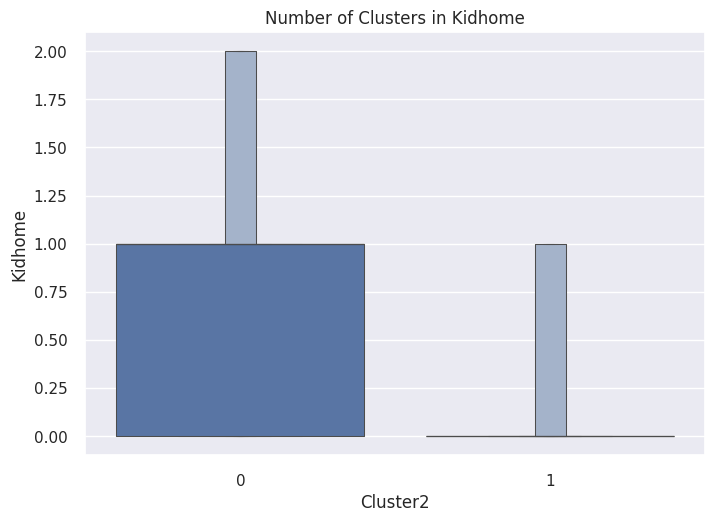

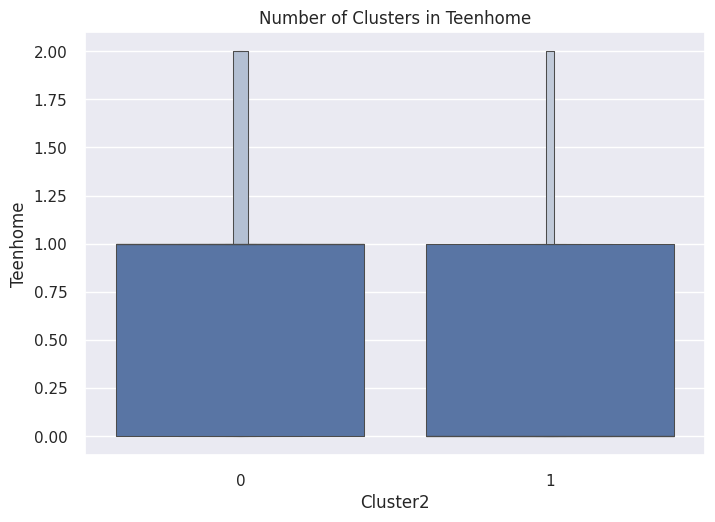

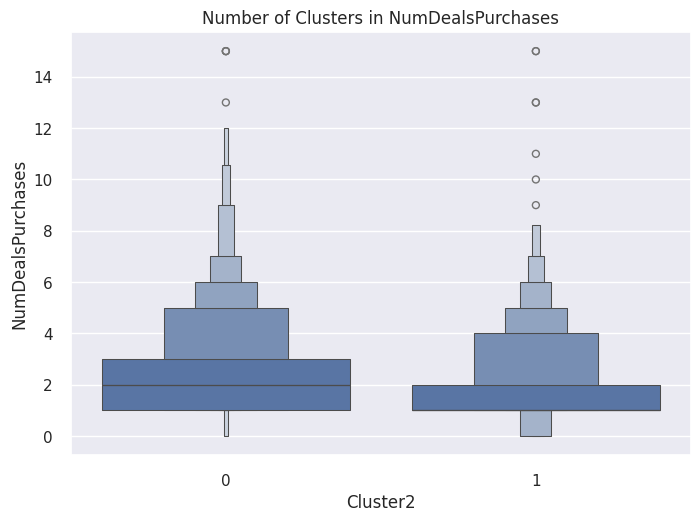

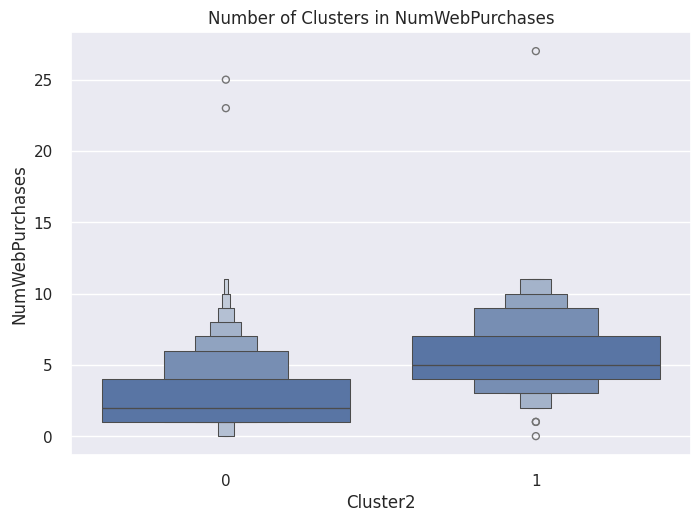

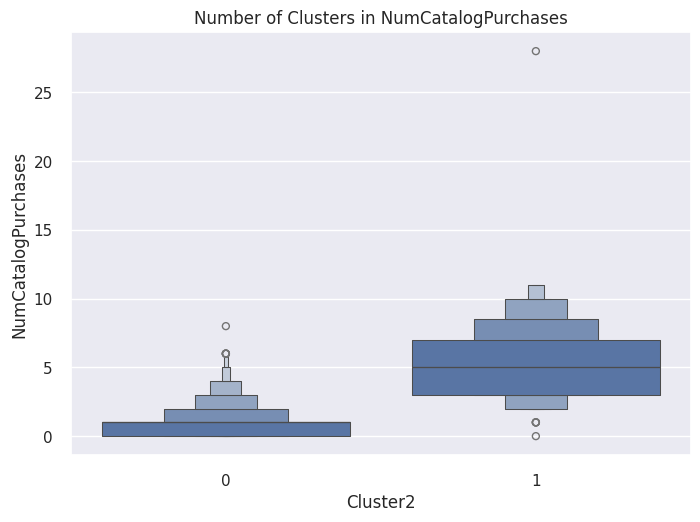

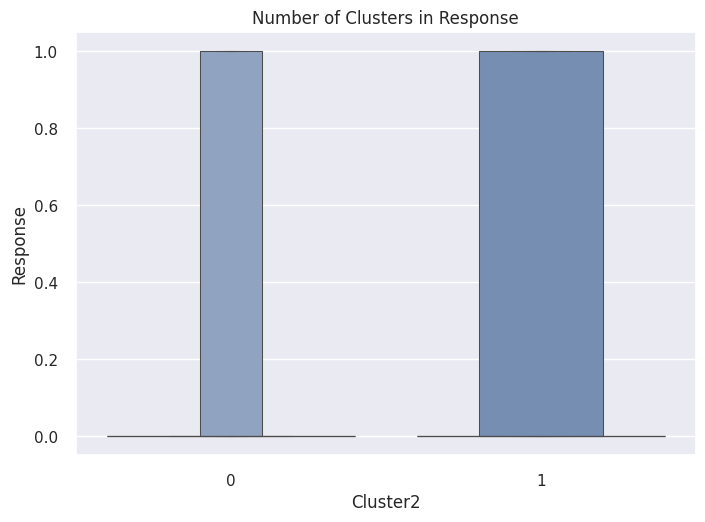

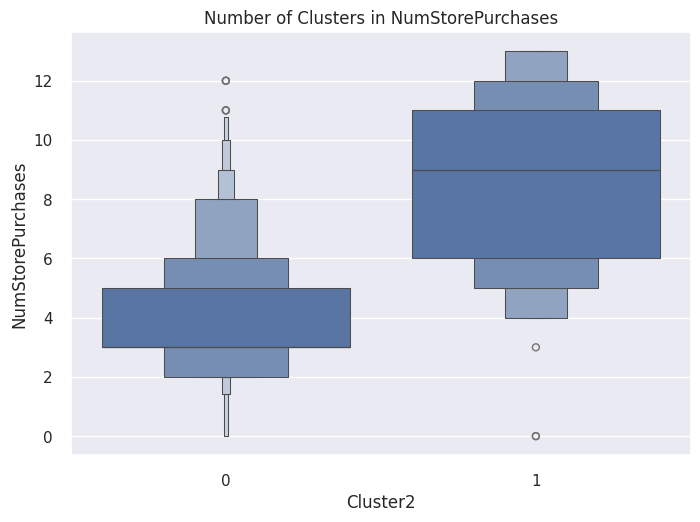

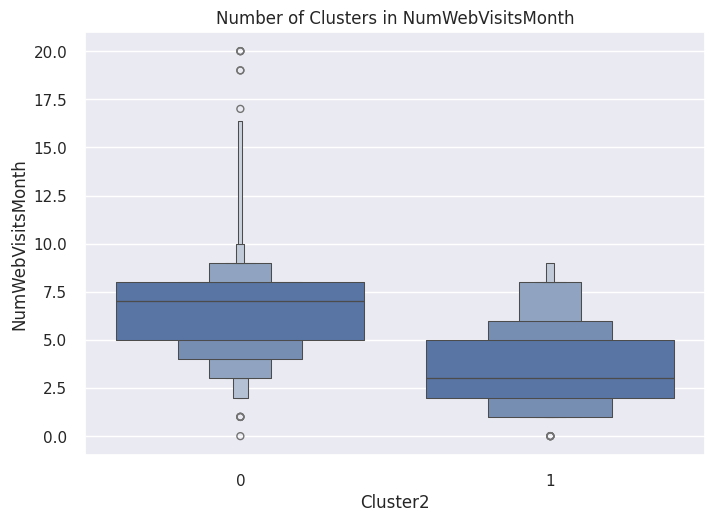

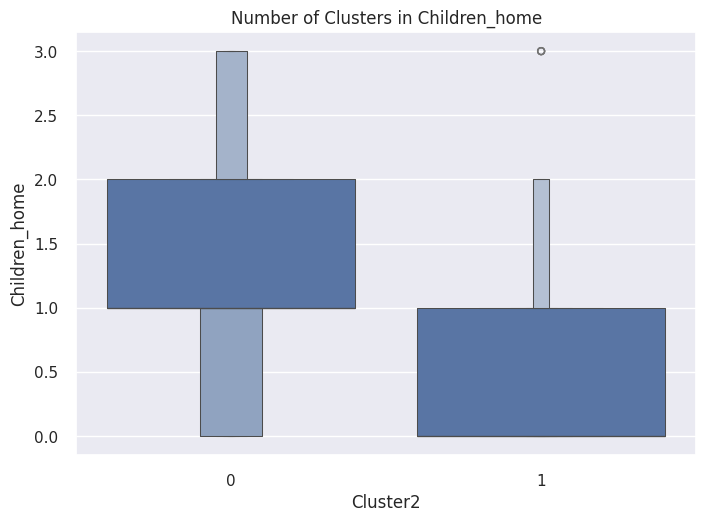

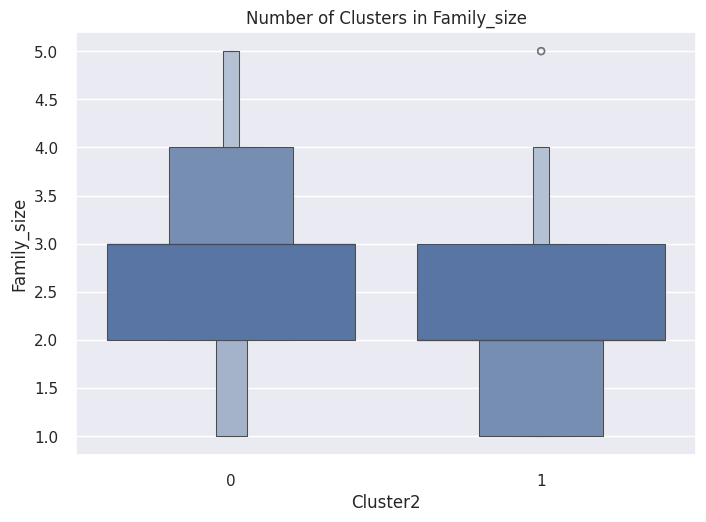

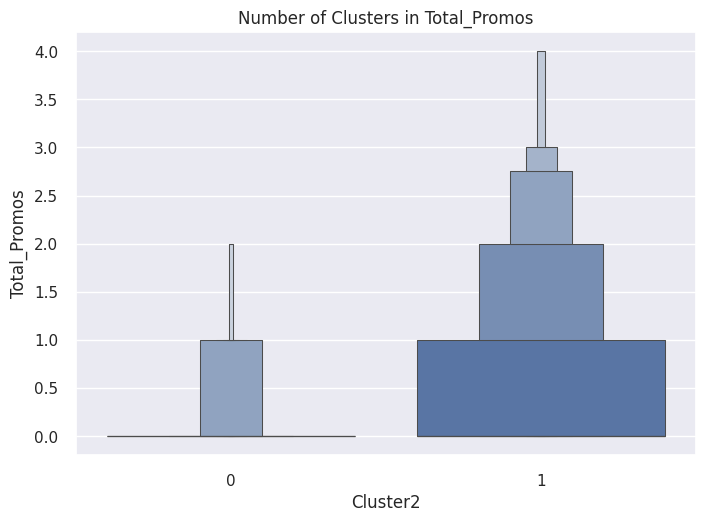

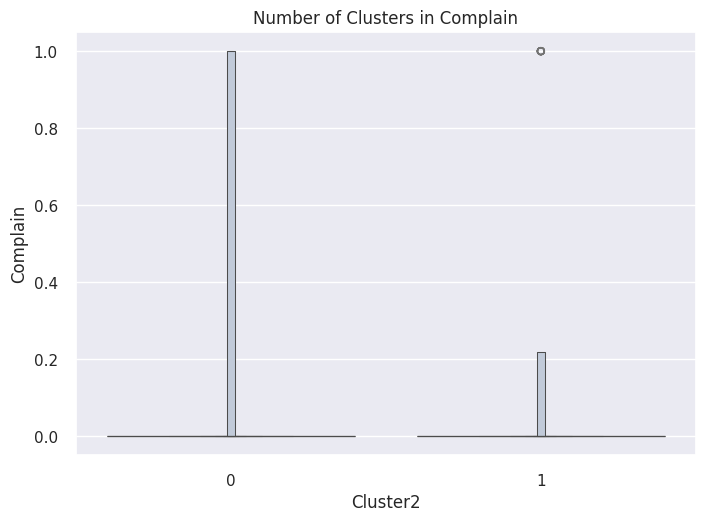

In [59]:
sns.set(style='darkgrid')
cluster_column = ['Kidhome', 'Teenhome','NumDealsPurchases','NumWebPurchases', 'NumCatalogPurchases',
                  'Response','NumStorePurchases','NumWebVisitsMonth','Children_home',
                  'Family_size', 'Total_Promos', 'Complain']
for col in cluster_column:
  plt.figure()
  pl=sns.boxenplot(y=final_data[col],x=final_data["Cluster2"])
  pl.set_title(f"Number of Clusters in {col}")
  plt.show()

<Figure size 800x550 with 0 Axes>

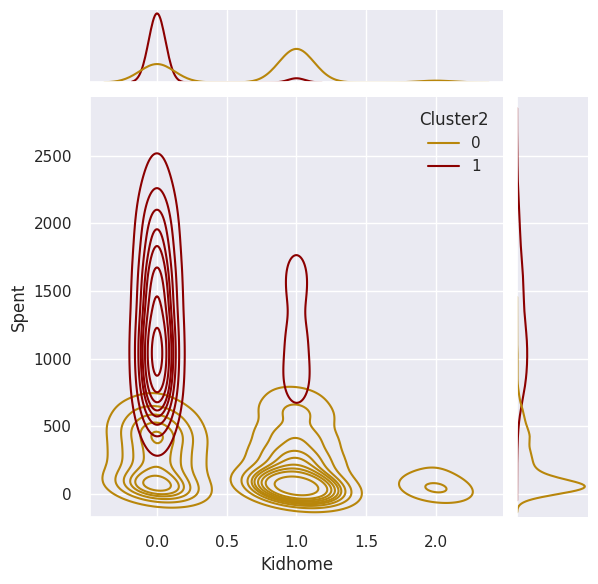

<Figure size 800x550 with 0 Axes>

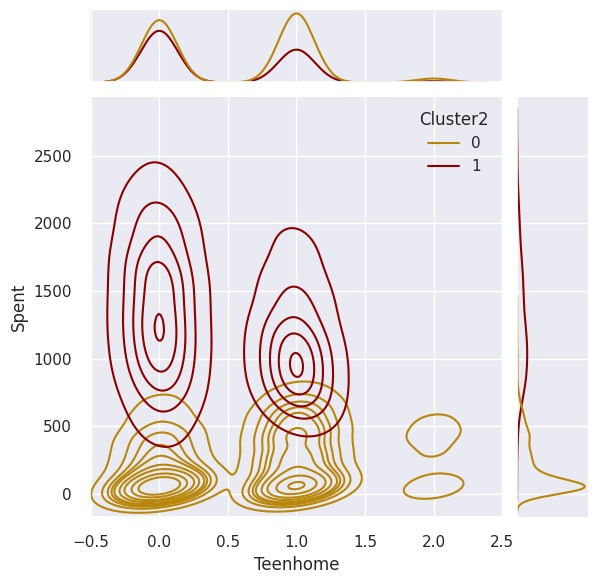

<Figure size 800x550 with 0 Axes>

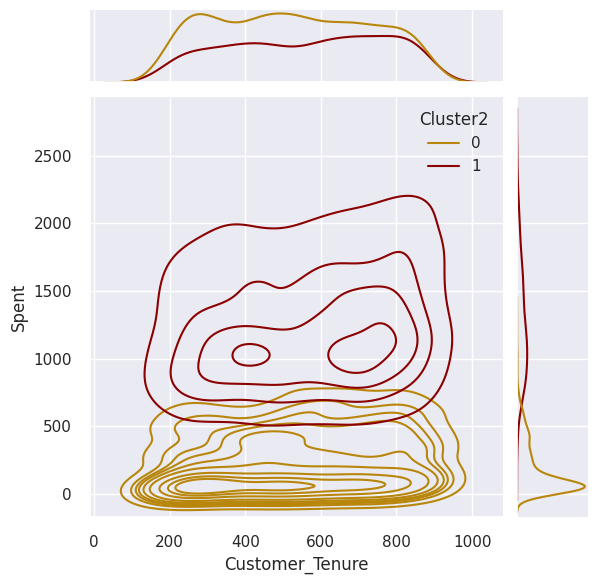

<Figure size 800x550 with 0 Axes>

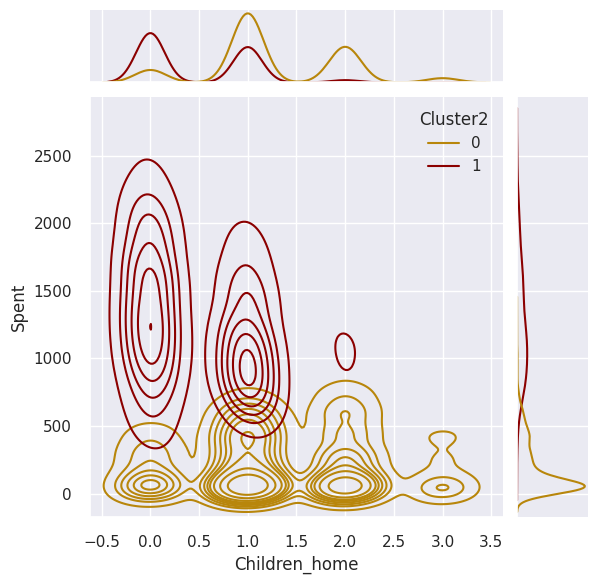

<Figure size 800x550 with 0 Axes>

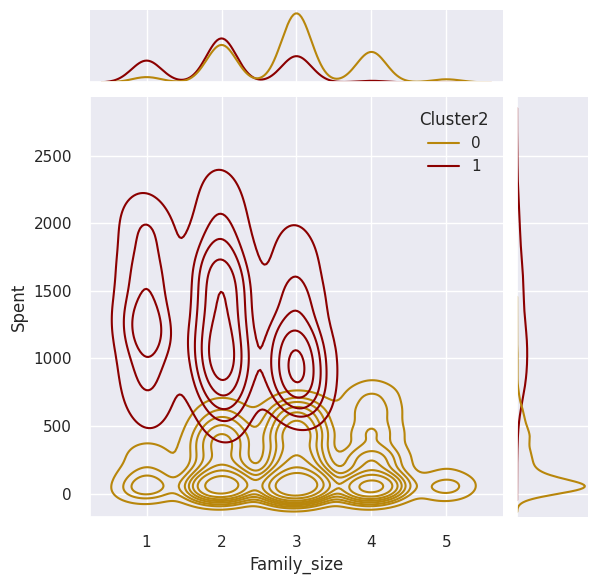

<Figure size 800x550 with 0 Axes>

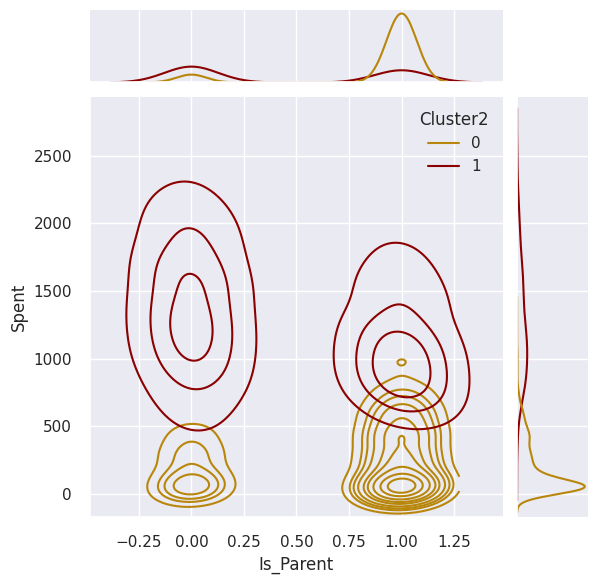

<Figure size 800x550 with 0 Axes>

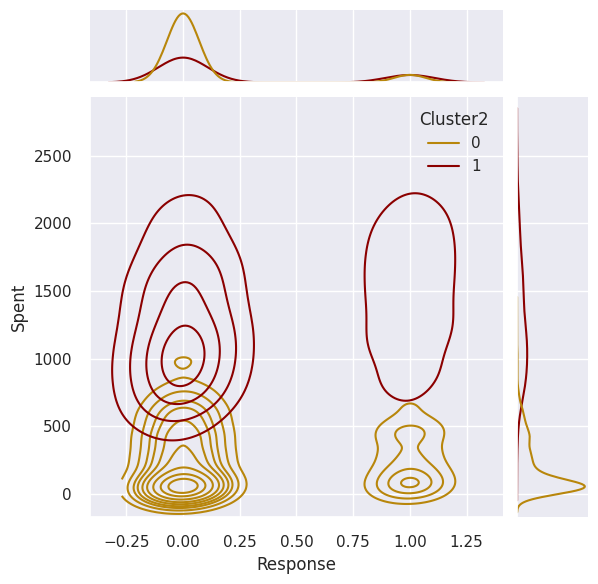

<Figure size 800x550 with 0 Axes>

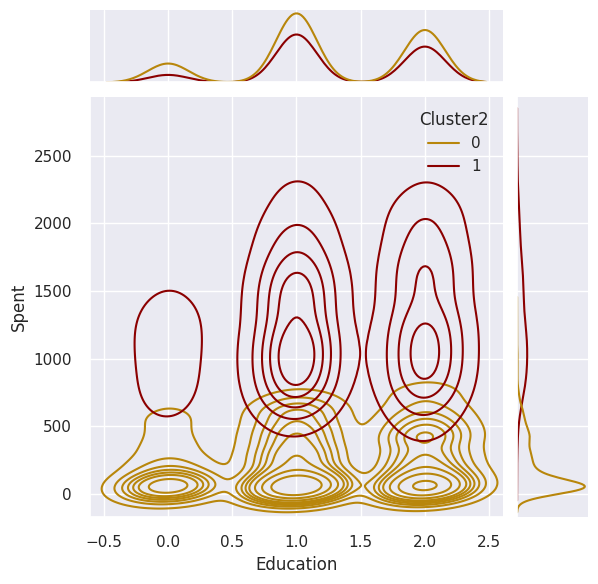

<Figure size 800x550 with 0 Axes>

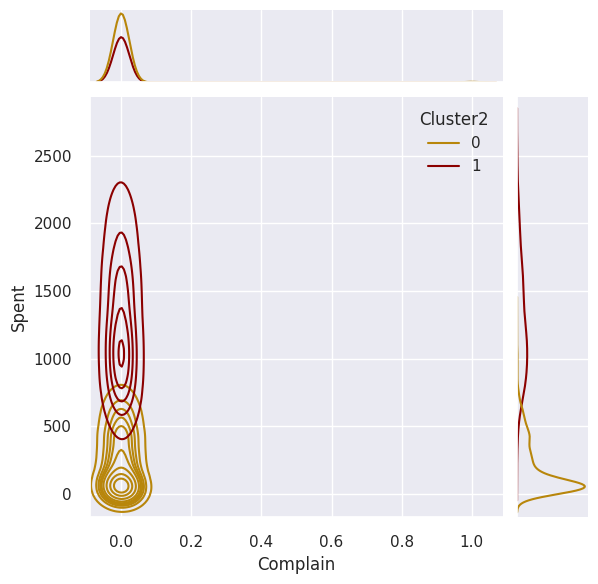

In [61]:
sns.set(style='darkgrid')
Personal = [ "Kidhome","Teenhome", 'Customer_Tenure', "Children_home", "Family_size",
            "Is_Parent", 'Response', "Education",'Complain']

pal = ["#B8860B","#8B0000"]

for columns in Personal:
    plt.figure()
    sns.jointplot(x=final_data[columns], y=final_data["Spent"], hue=final_data["Cluster2"],
                  kind="kde", palette=pal)
    plt.show()

**Summary:** This confirms the above observations

<Axes: xlabel='Cluster2', ylabel='Spent'>

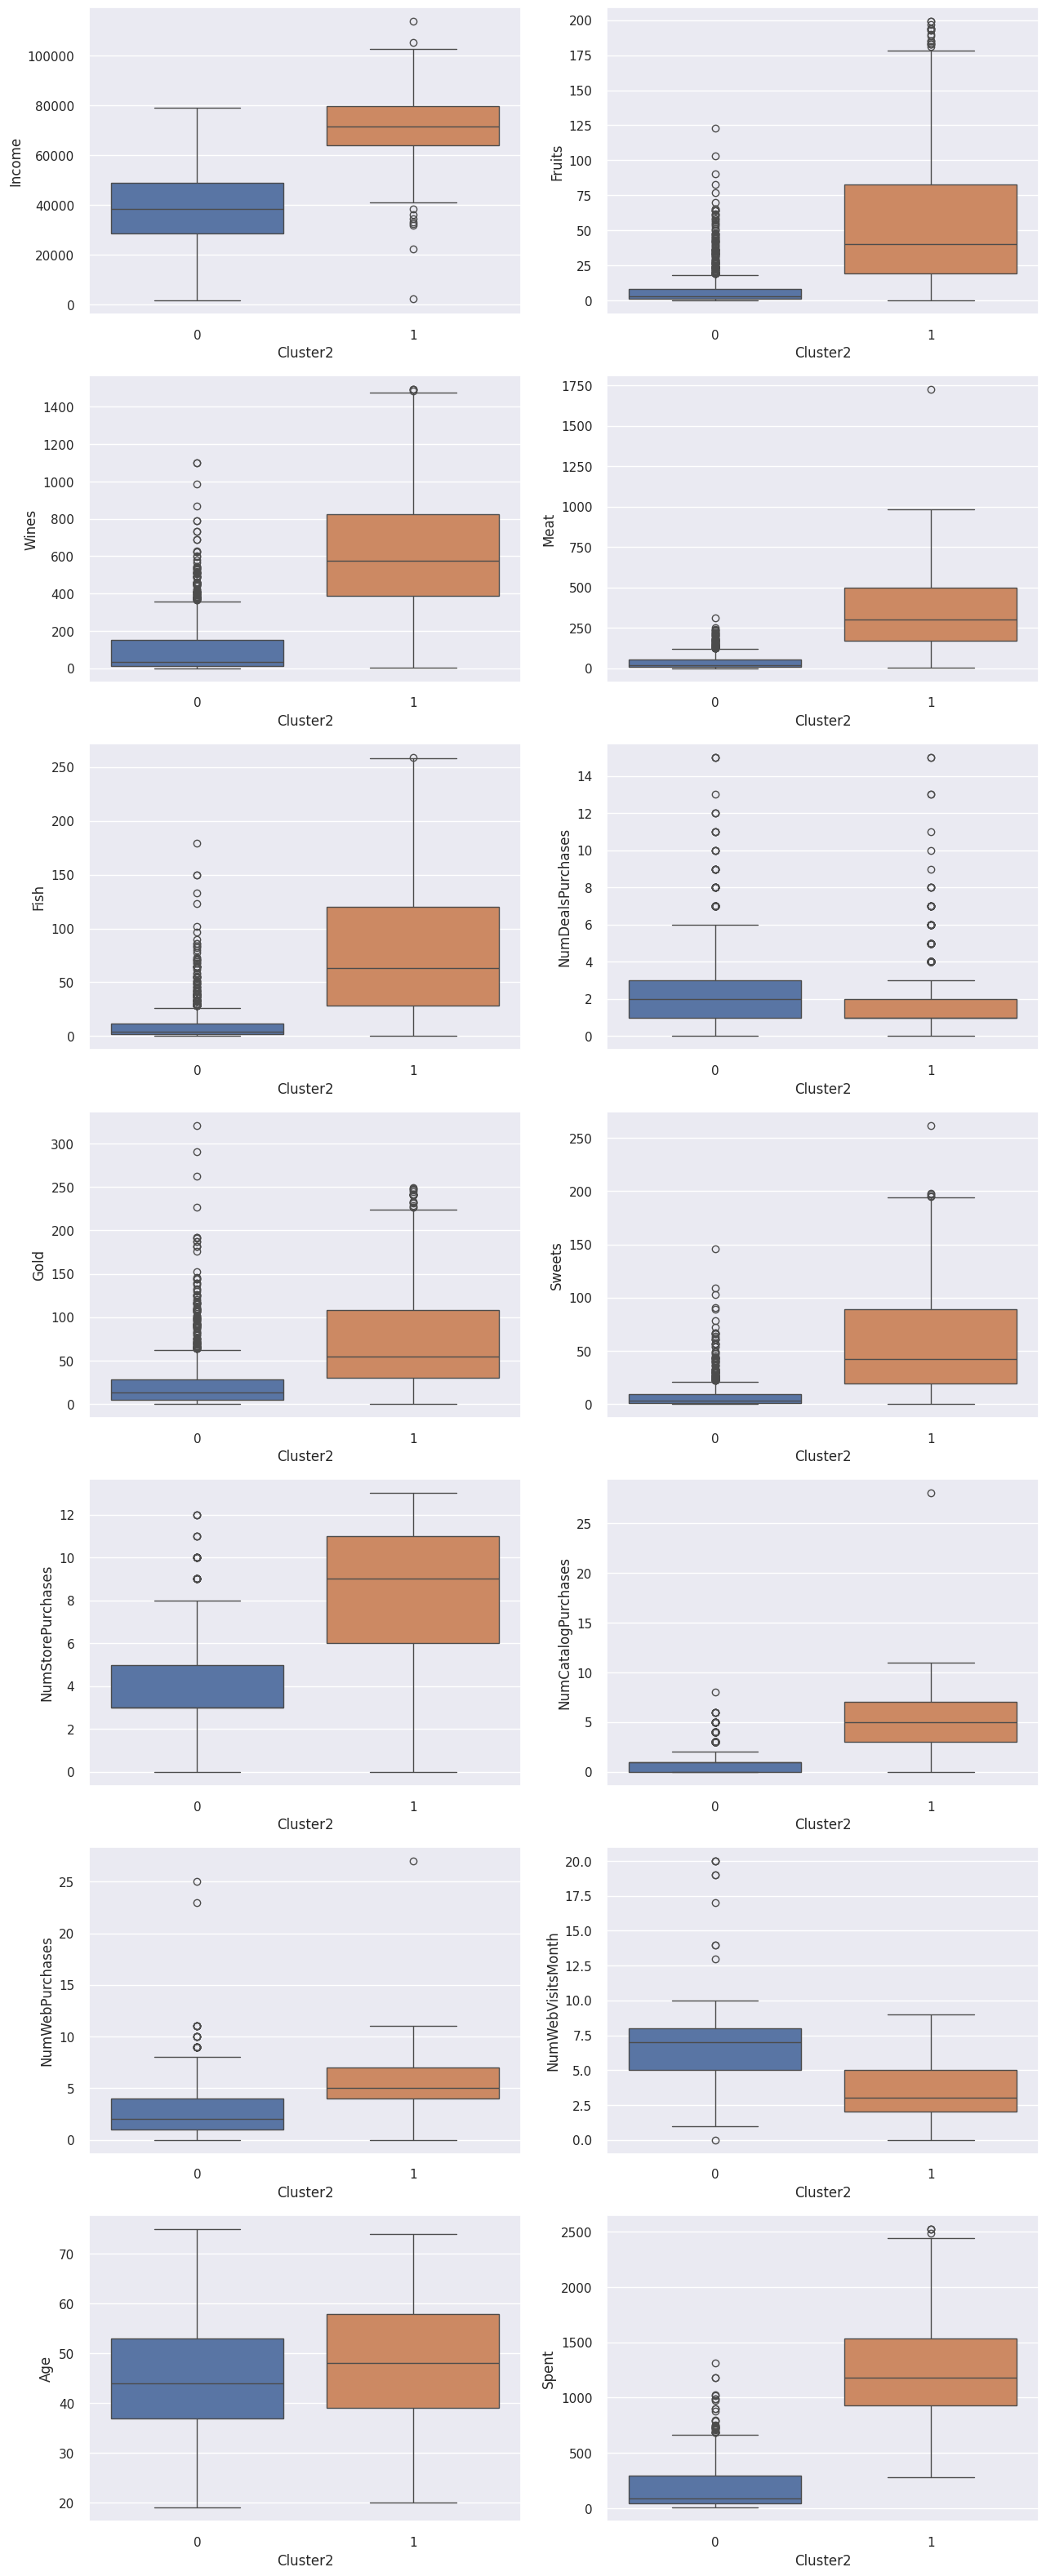

In [63]:
fig, axes = plt.subplots(7,2, figsize=(15,40))

sns.boxplot(x = 'Cluster2', y = 'Income', data = final_data, hue="Cluster2", legend=False, ax=axes[0][0])
sns.boxplot(x = 'Cluster2', y = 'Fruits', data = final_data, hue="Cluster2", legend=False, ax=axes[0][1])
sns.boxplot(x = 'Cluster2', y = 'Wines', data=final_data, hue="Cluster2", legend=False, ax=axes[1][0])
sns.boxplot(x = 'Cluster2', y = 'Meat', data=final_data, hue="Cluster2", legend=False, ax=axes[1][1])

sns.boxplot(x = 'Cluster2', y = 'Fish', data = final_data, hue="Cluster2", legend=False, ax=axes[2][0])
sns.boxplot(x = 'Cluster2', y = 'NumDealsPurchases', data = final_data, hue="Cluster2", legend=False, ax=axes[2][1])
sns.boxplot(x = 'Cluster2', y = 'Gold', data=final_data, hue="Cluster2", legend=False, ax=axes[3][0])
sns.boxplot(x = 'Cluster2', y = 'Sweets', data=final_data, hue="Cluster2", legend=False, ax=axes[3][1])

sns.boxplot(x = 'Cluster2', y = 'NumStorePurchases', data = final_data, hue="Cluster2", legend=False, ax=axes[4][0])
sns.boxplot(x = 'Cluster2', y = 'NumCatalogPurchases', data = final_data, hue="Cluster2", legend=False, ax=axes[4][1])
sns.boxplot(x = 'Cluster2', y = 'NumWebPurchases', data=final_data, hue="Cluster2", legend=False, ax=axes[5][0])
sns.boxplot(x = 'Cluster2', y = 'NumWebVisitsMonth', data=final_data, hue="Cluster2", legend=False, ax=axes[5][1])

sns.boxplot(x = 'Cluster2', y = 'Age', data = final_data, hue="Cluster2", legend=False, ax=axes[6][0])
sns.boxplot(x = 'Cluster2', y = 'Spent', data = final_data, hue="Cluster2", legend=False, ax=axes[6][1])


**Summary: A Better Numerical Representation of Clusters**

* Cluster 1 => More income, spends more, number of store purchase is more, catalog purchase is more

* Cluster 1 and 0 have somewhat same number of deals purchases and Age range

* Cluster 0 => spends less, web visit is more but web purchase is less, and less store purchase